**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [1]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /mobileye/RPT/users/kfirs/kfir_project/MSC_Project/notebook


## Install Segment Anything Model (SAM) and other dependencies

In [2]:
# !pip install 'git+https://github.com/facebookresearch/segment-anything.git'

In [3]:
# !pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'

In [4]:
# !pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

### Download SAM weights

In [5]:
# !mkdir -p {HOME}/weights
# !wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights

In [6]:
import os
# CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
CHECKPOINT_PATH = '/mobileye/RPT/users/kfirs/kfir_project/MSC_Project/SAM_checkpoints/sam_vit_h_4b8939.pth' #os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
# CHECKPOINT_PATH_WINDOWS = r'\\dfs.me-corp.lan\mobileye\RPT\users\kfirs\kfir_project\MSC_Project\SAM_checkpoints\sam_vit_h_4b8939.pth'
# print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

## Load Model

In [7]:
import torch
import tkinter as tk
from tkinter import filedialog
from IPython.display import display
import ipywidgets as widgets
import open3d as o3d
from open3d.cuda.pybind.geometry import TriangleMesh
import numpy as np
import cv2


# DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE = torch.device('cpu')
MODEL_TYPE = "vit_h"


# Function to open file dialog and get the file path
def select_file():
    root = tk.Tk()
    root.withdraw()  # Hide the main window
    file_path = filedialog.askopenfilename(filetypes=[("OBJ files", "*.obj")])
    path_widget.value = file_path

# Create a button widget
button_widget = widgets.Button(description="Select .obj file")

# Create a text widget to display the file path
path_widget = widgets.Text(
    value='',
    placeholder='File path will appear here',
    description='File Path:',
    disabled=False
)


def load_mesh(filename):
    """ Load a mesh from an OBJ file and return its vertices and normals. """
    mesh: TriangleMesh = o3d.io.read_triangle_mesh(filename)
    if not mesh.has_vertex_normals():
        mesh.compute_vertex_normals()
    vertices = np.asarray(mesh.vertices)
    normals = np.asarray(mesh.vertex_normals)  # Assume normals are already normalized
    return vertices, normals

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [8]:
from segment_anything import sam_model_registry, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

/homes/kfirs/.conda/envs/msc_project_env/lib/python3.10/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.loa

### Results visualisation with Supervision

As of version `0.5.0` Supervision has native support for SAM.

## Generate Segmentation with Bounding Box

The `SamPredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

In [9]:
mask_predictor = SamPredictor(sam)

# Define function to create ortho image

In [10]:
# Bind the function to the button click event
button_widget.on_click(lambda b: select_file())

# Display the widgets
display(button_widget)
display(path_widget)


Button(description='Select .obj file', style=ButtonStyle())

Text(value='', description='File Path:', placeholder='File path will appear here')

In [11]:
from orthograohic_image import capture_textured_image_and_depth_from_obj
obj_path = path_widget.value
image_path, output_depth_path, camera_params_path = capture_textured_image_and_depth_from_obj(obj_path,use_super_resolution=False)
print(image_path)
print(obj_path)

[Open3D WARNING] [ViewControl] ConvertFromPinholeCameraParameters() failed because window height and width do not match.
./images/S01_ortho.png
/mobileye/RPT/users/kfirs/kfir_project/MSC_Project/models/valid_models/S01/S01.obj


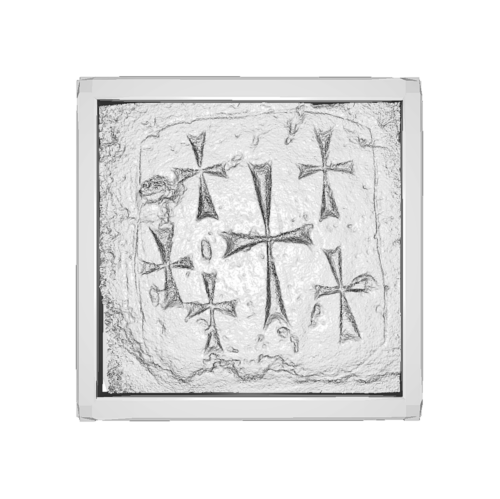

In [12]:
import matplotlib.pyplot as plt

# Load the orthoimage
ortho_image = cv2.imread(image_path)

# Display the orthoimage
plt.imshow(ortho_image)
plt.axis('off')
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
plt.show()

### Draw Box



**NOTE:** Execute cell below and use your mouse to draw bounding box on the image 👇

In [13]:
from numpy import ndarray
from typing import Union
# helper function that loads an image before adding it to the widget

import base64

def encode_image(input: Union[str,ndarray]):
    if isinstance(input, str):     
        with open(input, "rb") as image:
            image_bytes = image.read()
    else:
        image_bytes = cv2.imencode('.jpg', input)[1]
        
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

In [14]:
from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget( classes=['cross'])
widget.image = encode_image(image_path)

# Set resolution of the image
widget.width = ortho_image.shape[1]
widget.height = ortho_image.shape[0]


widget

BBoxWidget(classes=['cross'], colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377…

### Generate masks with SAM

**NOTE:** `SamPredictor.predict` method takes `np.ndarray` `box` argument in `[x_min, y_min, x_max, y_max]` format. Let's reorganise your data first

In [15]:
import numpy as np

box = widget.bboxes[0]
box = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])

boxes = []
for box in widget.bboxes:
    boxes.append(np.array([
        box['x'],
        box['y'],
        box['x'] + box['width'],
        box['y'] + box['height']
    ]))
    
# Print the box coordinates
boxes

[array([638, 512, 779, 717]),
 array([604, 250, 744, 457]),
 array([337, 255, 469, 455]),
 array([367, 560, 490, 751]),
 array([269, 465, 390, 646])]

In [16]:
import cv2
import numpy as np
import supervision as sv

# Use the orthoimage as the input image
image_bgr = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# Set the image for the mask predictor
mask_predictor.set_image(image_rgb)

# Initialize lists to store masks, scores, and logits for each box
all_masks = []
all_scores = []
all_logits = []
best_masks = []
best_scores = []


# Predict masks for each box
for box in boxes:
    masks, scores, logits = mask_predictor.predict(
        box=box,
        multimask_output=True,
    )
    all_masks.append(masks)
    all_scores.append(scores)
    all_logits.append(logits)
    
    mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask
    
    # Select the mask with the highest score
    best_index = np.argmax(scores)
    best_masks.append(masks[best_index])
    best_scores.append(scores[best_index])
    
    # Run another round of prediction with the best masks as mask_input to refine the masks
    best_m, best_s, _ = mask_predictor.predict(
        box=box,
        mask_input=mask_input[None, :, :],
        multimask_output=False,
    )
    
    # if the new mask is better, replace the previous mask
    if best_s > scores[best_index]:
        print(f"Improved mask score from after refinement: {scores[best_index]:.3f} -> {best_s[0]:.3f}")
        
        # Update All masks and scores
        all_masks[-1] = np.concatenate((all_masks[-1], best_m), axis=0)
        all_scores[-1] = np.concatenate((all_scores[-1], best_s), axis=0)
        

In [17]:
from functools import partial

# Function to display the selected mask using matplotlib
def display_selected_mask(box_index, output_widget):
    with output_widget:
        output_widget.clear_output(wait=True)
        plt.figure(figsize=(4, 4))
        plt.imshow(best_masks[box_index], cmap='gray')
        plt.title(f"Selected mask for box {box_index} with score {best_scores[box_index]:.3f}")
        plt.axis('off')
        plt.show()

# Interactive widget to select the best mask
def select_best_mask(box_index, mask_index, output_widget, event):
    global best_masks, best_scores
    best_masks[box_index] = all_masks[box_index][mask_index]
    best_scores[box_index] = all_scores[box_index][mask_index]
    display_selected_mask(box_index, output_widget)

# Create interactive widgets for each box
for i, (masks, scores) in enumerate(zip(all_masks, all_scores)):
    title = widgets.HTML(f"<h4>Box {i} Masks</h4>")
    images = [widgets.Image(value=cv2.imencode('.png', mask * 255)[1].tobytes(), layout=widgets.Layout(width='200px', height='200px')) for mask in masks]
    buttons = [widgets.Button(description=f"Score: {score:.3f}", layout=widgets.Layout(width='auto')) for score in scores]
    output_widget = widgets.Output()

    for j, button in enumerate(buttons):
        button.on_click(partial(select_best_mask, i, j, output_widget))
    
    display(title, widgets.HBox(images), widgets.HBox(buttons), output_widget)
    display_selected_mask(i, output_widget)

# Convert lists to numpy arrays
best_masks = np.array(best_masks)
best_scores = np.array(best_scores)

HTML(value='<h4>Box 0 Masks</h4>')

Output()

HTML(value='<h4>Box 1 Masks</h4>')

Output()

HTML(value='<h4>Box 2 Masks</h4>')

Output()

HTML(value='<h4>Box 3 Masks</h4>')

Output()

HTML(value='<h4>Box 4 Masks</h4>')

Output()

### Results visualisation with Supervision

SupervisionWarnings: red is deprecated: `Color.red()` is deprecated and will be removed in `supervision-0.22.0`. Use `Color.RED` instead.
SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


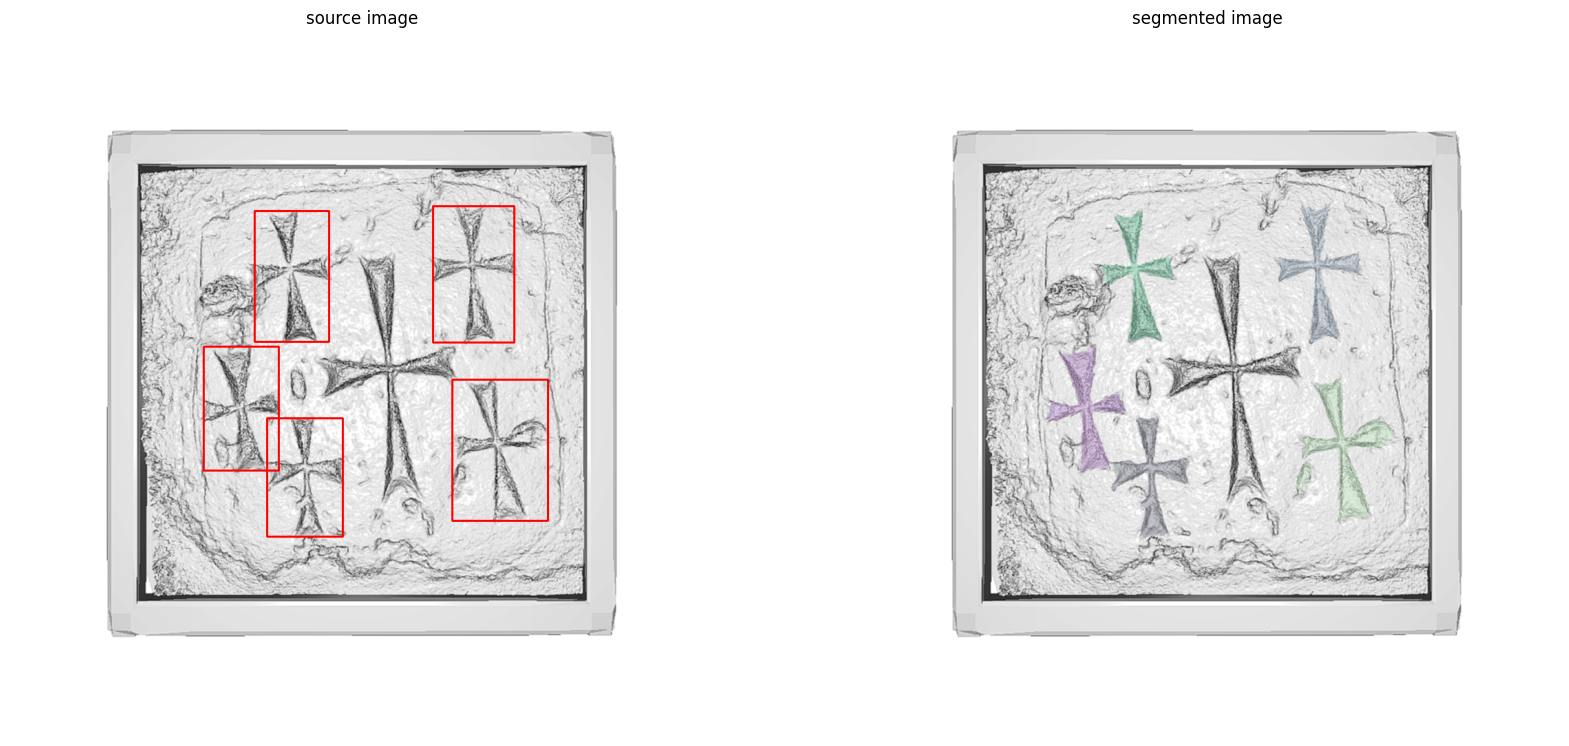

In [19]:

# Create a color lookup table with unique bright colors for each mask
num_masks = best_masks.shape[0]
mask_colors  = np.random.randint(100, 255, (num_masks, 3))

# Create detections object with the best masks
detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=best_masks),
    mask=best_masks
)

# Annotate the image with boxes
box_annotator = sv.BoxAnnotator(color=sv.Color.red())
source_image = box_annotator.annotate(scene=image_rgb.copy(), detections=detections, skip_label=True)

# Annotate the image with masks using unique colors
segmented_image = image_rgb.copy()
for i, mask in enumerate(detections.mask):
    color = sv.Color(*mask_colors [i])
    mask_annotator = sv.MaskAnnotator(color=color)
    mask_detections = sv.Detections(xyxy=np.array([detections.xyxy[i]]), mask=np.array([mask]))
    segmented_image = mask_annotator.annotate(scene=segmented_image, detections=mask_detections, custom_color_lookup=lambda x: color)

# Display the images in a grid and increase the size of the grid
sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    size=(20, 10),
    titles=['source image', 'segmented image']
)

### Masks and their scores visualisation

In [20]:
# masks and mask color shapes and types
print("best_masks:", best_masks.shape, best_masks.dtype)
print("mask_colors:", mask_colors.shape, mask_colors.dtype)

best_masks: (5, 1024, 1024) bool
mask_colors: (5, 3) int64


In [21]:
# Save the masks and mask colors the same folder as the image with a prefix
masks_path = image_path.replace(".png", "_masks.npy")
colors_path = image_path.replace(".png", "_colors.npy")

np.save(masks_path, best_masks)
np.save(colors_path, mask_colors)

# Display the paths to the saved masks and colors
masks_path, colors_path

('./images/S01_ortho_masks.npy', './images/S01_ortho_colors.npy')

In [22]:
from project_masks_to_3d import project_masks_to_mesh
# Apply the masks to the mesh
masked_point_cloud = project_masks_to_mesh(obj_path, masks_path, colors_path, camera_params_path, output_depth_path)

Processing black mask: 100%|██████████| 1014159/1014159 [00:04<00:00, 212996.78it/s]
Assigning colors to mesh vertices: 689698it [00:07, 86471.11it/s]


[Open3D WARNING] Write OBJ can not include triangle normals.


In [ ]:
print(masks_path)
print(colors_path)
print(camera_params_path)
print(output_depth_path)

In [ ]:
from extract_and_save_masked_areas import extract_and_save_masked_areas

output_dir = os.path.join(os.path.dirname(obj_path), "masked_areas")

### Extract the 3D masked mesh from the masked point cloud
extract_and_save_masked_areas(masked_point_cloud, output_dir)

In [ ]:
from extract_and_save_masked_areas import display_masked_areas

### Display the masked areas
display_masked_areas(output_dir)